In [1]:
# init

import math
import numpy as np
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
from scipy.misc import imresize
from skimage import feature

In [2]:
# helpers

# plot images, list are dislayed in subplots
def plot(imgs, title=None):
    # make sure input is a list
    if not isinstance(imgs, list):
        imgs = [imgs]
    
    plt.figure()
        
    for i in range(len(imgs)):
        if(title is not None): 
            plt.suptitle(title)
        plt.subplot(1, len(imgs), i+1)
        plt.axis("off")
        plt.imshow(imgs[i])
        

# create empty list of given size
def empty(size):
    return [None]*size

# calc sigmoid function
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# calculate mean column of image
def mean_column(img):
    # sum up columns
    colsum = np.sum(img, axis=0)
    
    # get left and right boundaries
    left = np.min(np.nonzero(colsum))
    right = np.max(np.nonzero(colsum))
    
    # calc cumulative sum
    cumsum = np.cumsum(colsum[left:right])
    
    # return index closest to mean
    return left+(np.abs(cumsum-np.mean(cumsum))).argmin()

# calculate masks from seg
def mask2(img):
    return img[:,:,0]>200
    
def mask3(img):
    return np.tile(mask2(img), (3,1,1)).transpose((1,2,0))

In [3]:
# choose data_set to be used
data_set = 'test'

# load data
data = pickle.load(open("./data/data-%s.pkl" % data_set, 'rb'))
c = data['rgb'].shape[0]
print('%i samples' % c)

r = range(c)

# init 'preprocessed' dict
data_pp = {'seg':empty(c),'rgb':empty(c),'dep':empty(c),'subject':empty(c),'label':empty(c),'valid': empty(c)}

# set labels if training set
if(data_set == 'train'):
    data_pp['label'] = data['gestureLabels']

# copy valid-flags and subjects from original data
data_pp['valid'] = data['valid']
data_pp['subject'] = data['subjectLabels']

8190 samples


In [4]:
# filter invalid samples

if('valid' not in data.keys()):
    data['valid'] = empty(c)

    for i, img in enumerate(data['segmentation']):
        data['valid'][i] = img.sum() > 0

    pickle.dump(data, open("./data/data-%s.pkl" % data_set, 'wb'))

    print('done')
else:
    print('nothing to do')

nothing to do


In [6]:
# crop and scale
for i in r:
    if(not data_pp['valid'][i]):
        continue
        
    sample = data['segmentation'][i][:, :, 0]
    
    # top border
    top = np.min(np.nonzero(np.any(sample, axis=1)))
    
    # crop and scale segmentation to calculate body area
    bottom = 120
    if not np.any(sample[117:119, :]):
        bottom = np.max(np.nonzero(np.any(sample, axis=1)))
    
    # approximate center of body
    mean = mean_column(sample[top:bottom, :])
    
    # calc scale factor
    height = int(bottom-top)
    factor = 120/height
    
    # pad image in case we go out of bounds
    seg_tmp = data['segmentation'][i].copy()
    seg_tmp = np.lib.pad(seg_tmp, ((0, 0), (60, 60), (0, 0)), 'constant')
    
    # calc left and right crop
    left = 60+mean-int(60/factor)
    right = 60+mean+int(60/factor)
    
    # scale cropped image
    seg = cv2.resize(seg_tmp[top:bottom, left:right, :] ,(120, 120), interpolation=cv2.INTER_CUBIC)
    
    # calculate std of masked depth
    mask = mask2(data['segmentation'][i])
    dep_masked = data['depth'][i]*mask
    std = np.std(dep_masked[dep_masked>0])
    
    # calculate body area (sum of pixel vals, this is why we scale)
    pix = seg.sum()

    # calculate prob of close-up photograph
    p_pix = sigmoid((pix-3250000)/90000)
    p_std = sigmoid((std-9.5))
    p = p_pix*p_pix*p_std
    
    # adjust bottom crop
    if not np.any(sample[117:119, :]):
        bottom = top+int((bottom-top)*0.5)
    elif(p < 0.125):
        bottom = top+int((bottom-top)*0.65)
        
    # center and scale once more, this time for all three image types
    # use new bottom crop to get better mean
    mean = mean_column(sample[top:bottom, :])
    
    height = int(bottom-top)
    factor = 120/height
    
    left = 60+mean-int(60/factor)
    right = 60+mean+int(60/factor)
    
    seg_tmp = data['segmentation'][i].copy()
    seg_tmp = np.lib.pad(seg_tmp, ((0, 0), (60, 60), (0, 0)), 'constant')
    
    rgb_tmp = data['rgb'][i].copy()
    rgb_tmp = np.lib.pad(rgb_tmp, ((0, 0), (60, 60), (0, 0)), 'constant')
    
    dep_tmp = data['depth'][i].copy()
    dep_tmp = np.lib.pad(dep_tmp, ((0, 0), (60, 60)), 'constant')
    
    seg = cv2.resize(seg_tmp[top:bottom, left:right, :] ,(120, 120), interpolation=cv2.INTER_CUBIC)
    rgb = cv2.resize(rgb_tmp[top:bottom, left:right, :] ,(120, 120), interpolation=cv2.INTER_CUBIC)
    dep = cv2.resize(dep_tmp[top:bottom, left:right   ] ,(120, 120), interpolation=cv2.INTER_CUBIC)
    
    # mask rgb and depth
    rgb *= mask3(seg)
    dep *= mask2(seg)
    
    # store to new dict
    data_pp['seg'][i] = seg
    data_pp['rgb'][i] = rgb
    data_pp['dep'][i] = dep
    
print('done')

done


In [7]:
# clear some memory
data = None

In [8]:
# normalize depth to mean 127
for i in r:
    if(not data_pp['valid'][i]):
        continue
        
    img = data_pp['dep'][i]
    
    offset = int(img[img>0].mean() - 127)
    
    # in case some pixels are < offset, set them to 0 to avoid integer overflow (shouldn't happen)
    if(img[img>0].min() < offset):
        img[img<offset] = 0
        
    img[img>0] = img[img>0]-offset
    
print('done')

done


/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


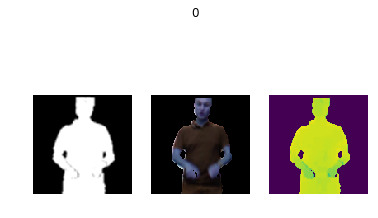

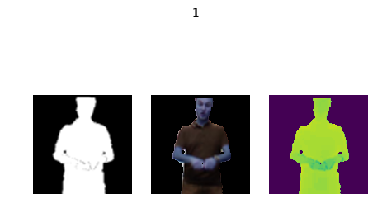

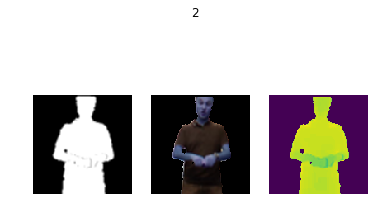

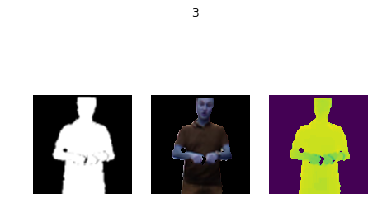

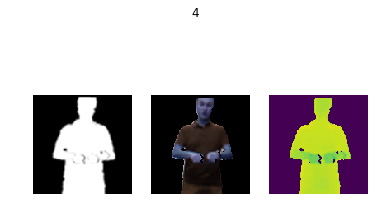

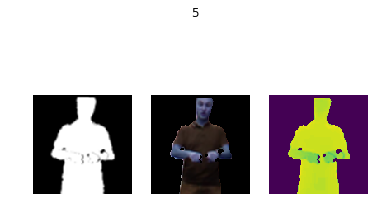

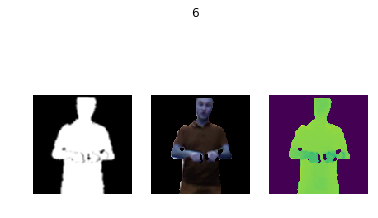

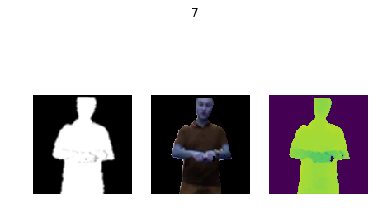

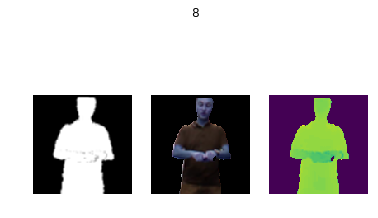

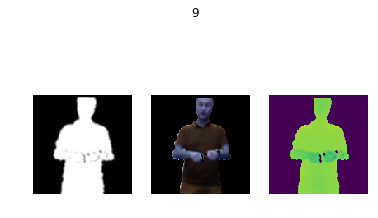

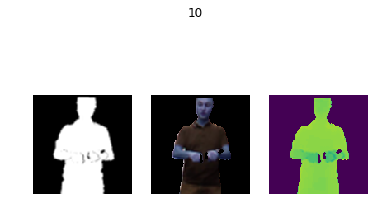

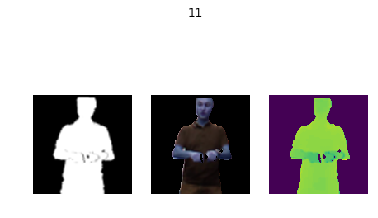

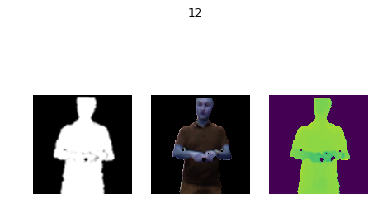

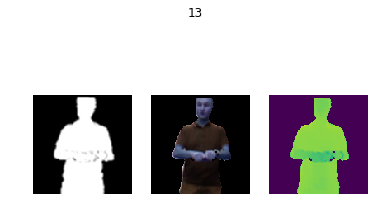

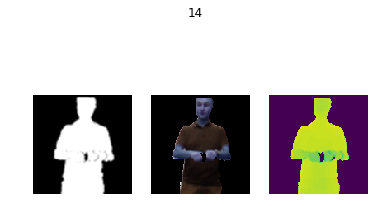

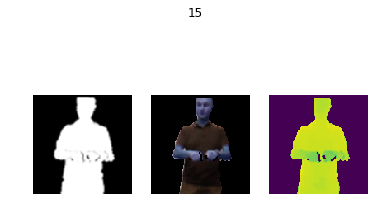

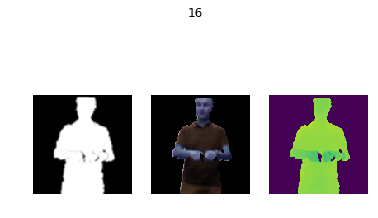

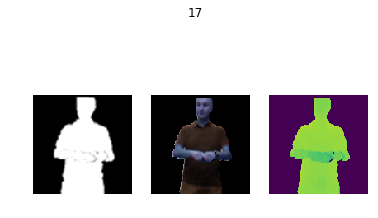

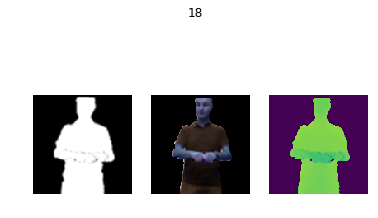

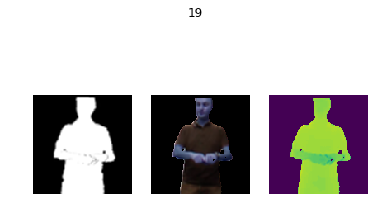

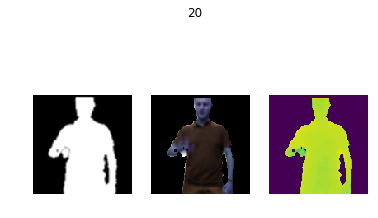

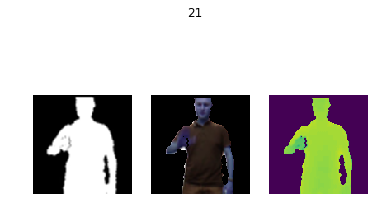

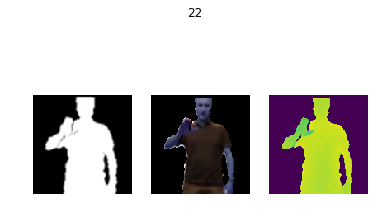

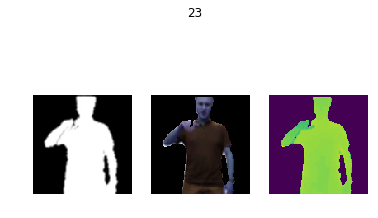

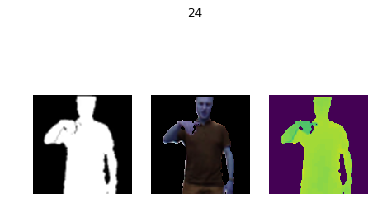

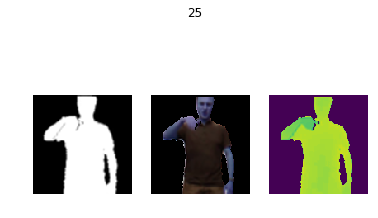

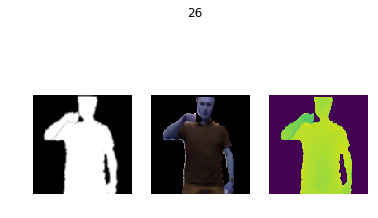

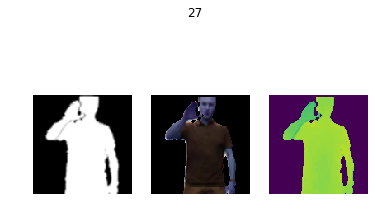

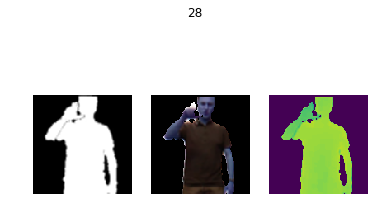

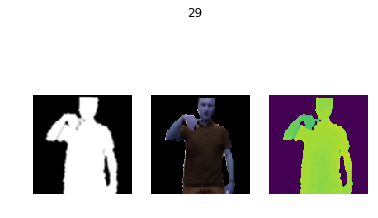

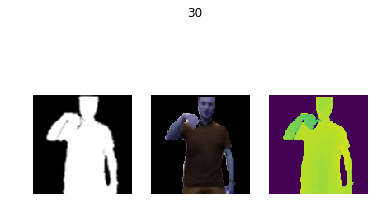

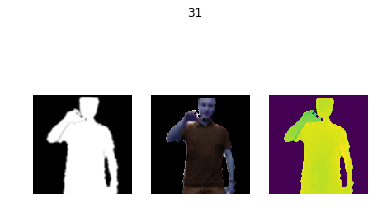

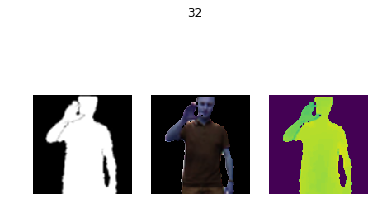

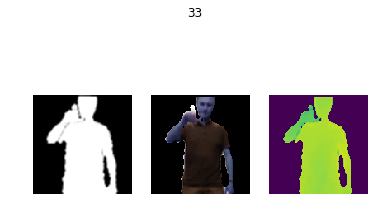

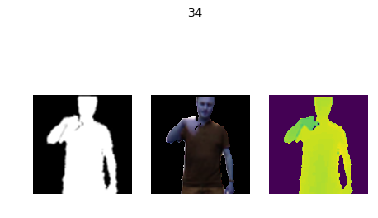

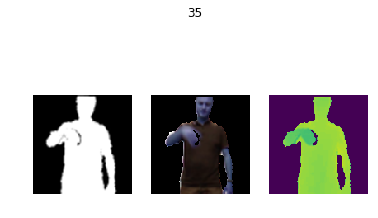

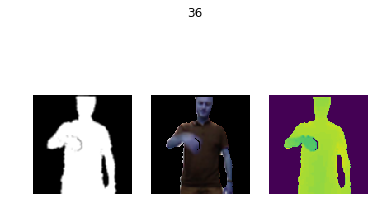

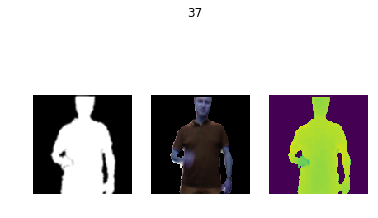

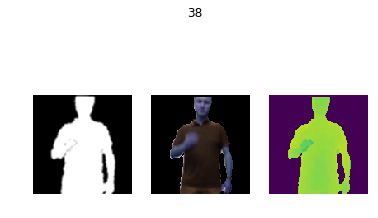

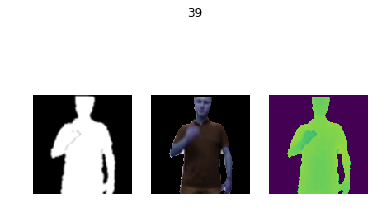

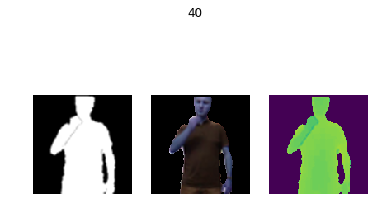

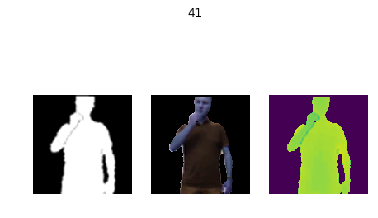

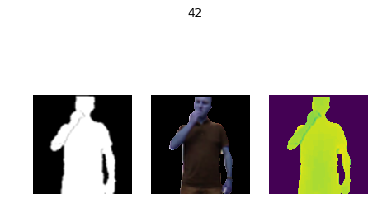

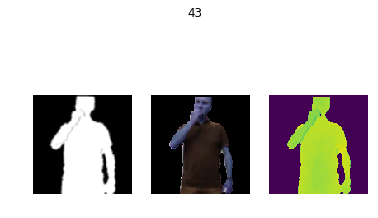

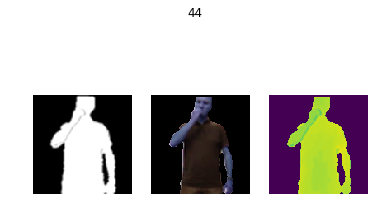

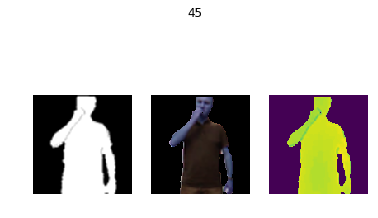

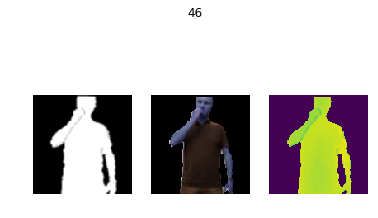

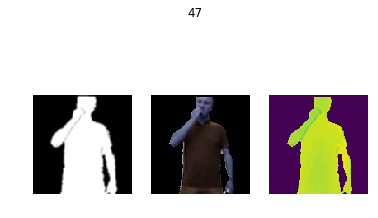

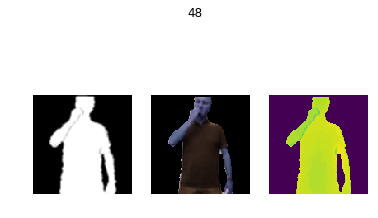

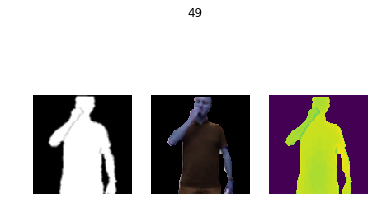

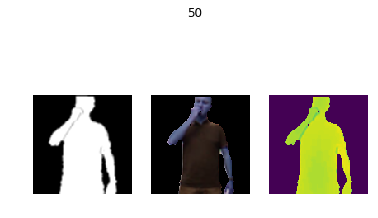

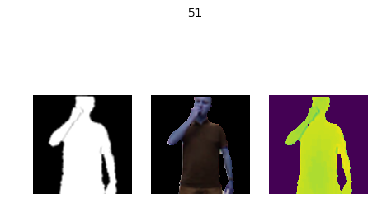

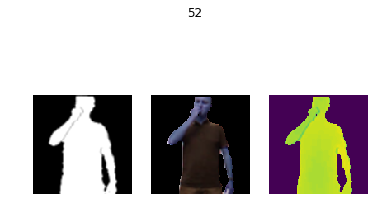

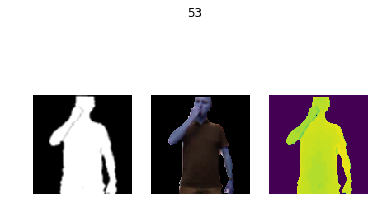

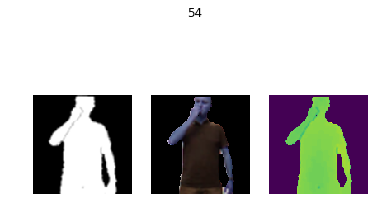

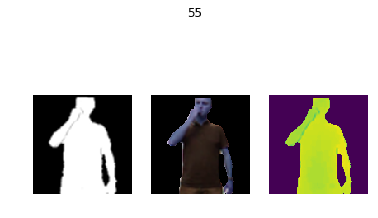

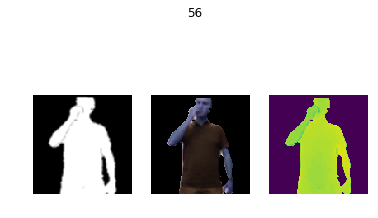

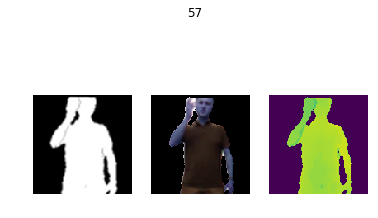

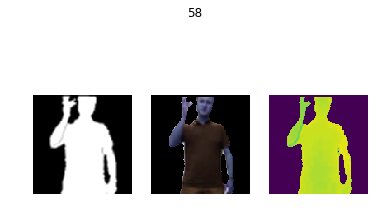

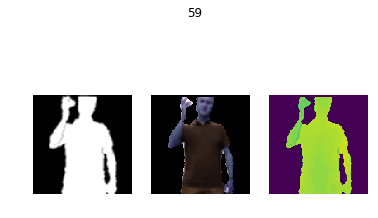

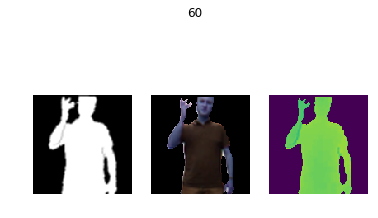

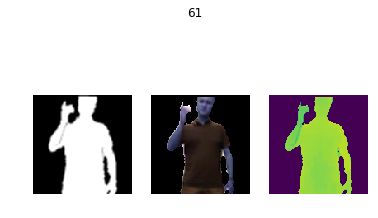

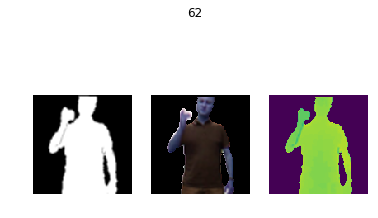

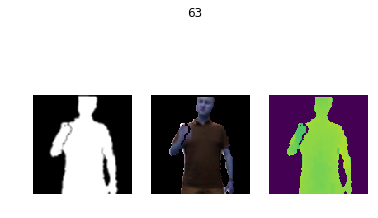

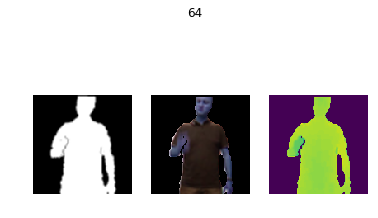

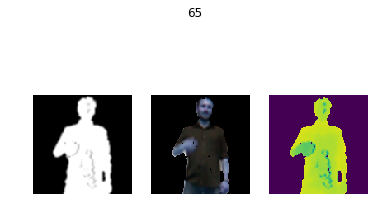

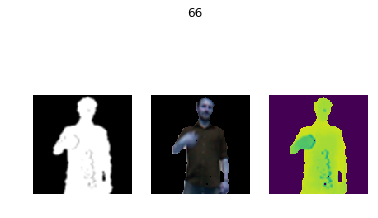

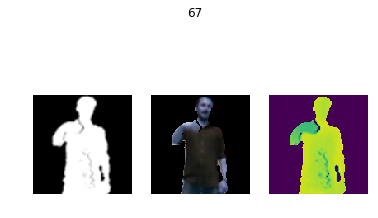

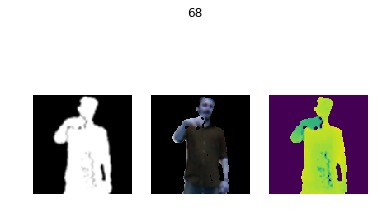

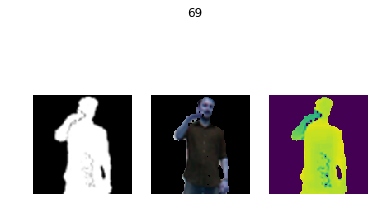

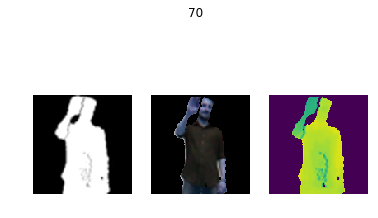

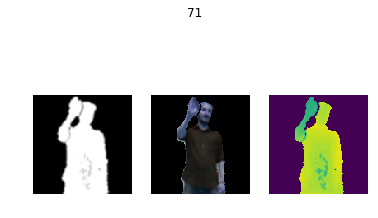

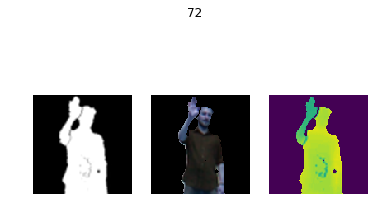

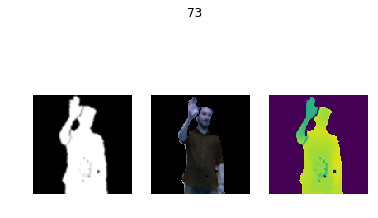

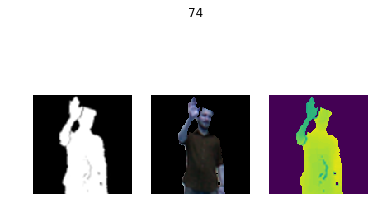

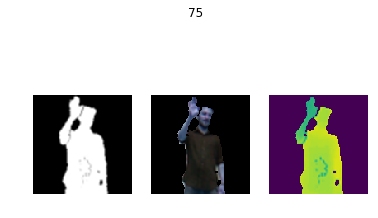

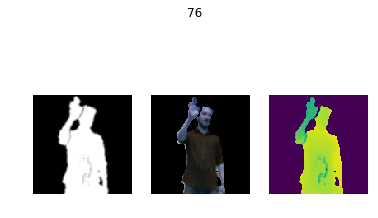

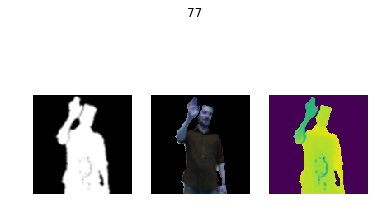

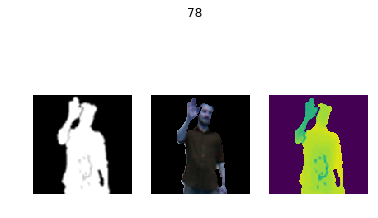

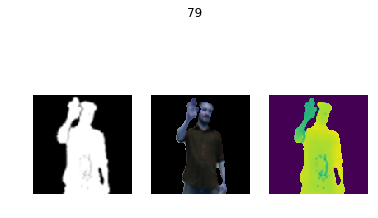

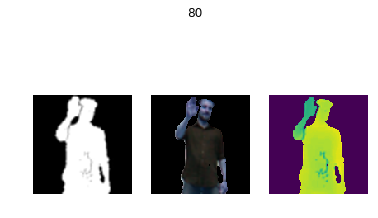

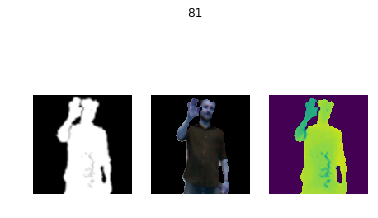

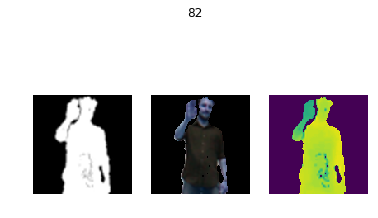

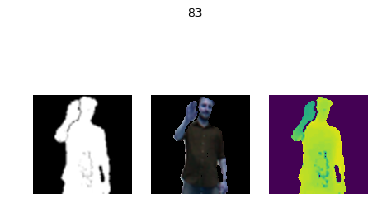

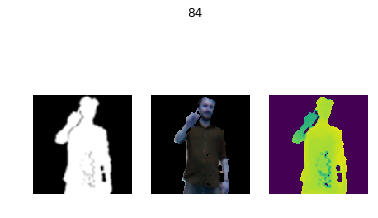

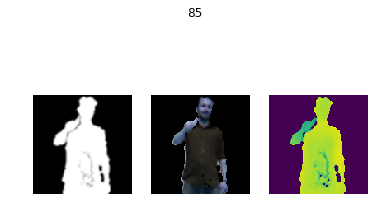

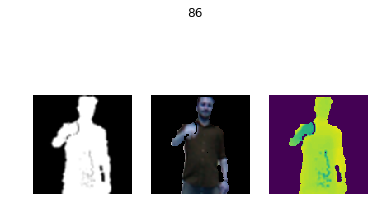

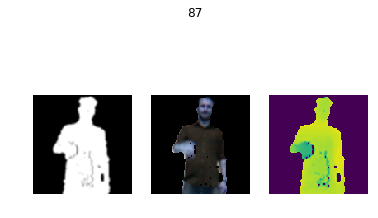

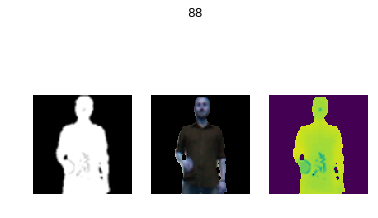

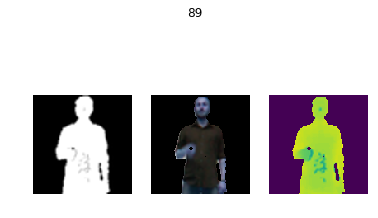

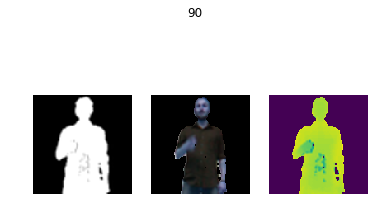

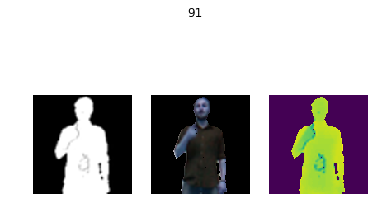

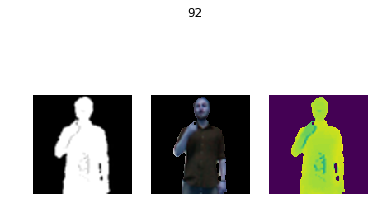

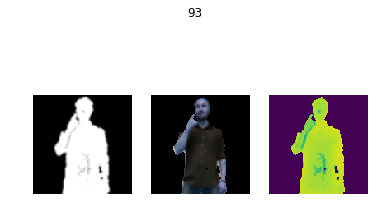

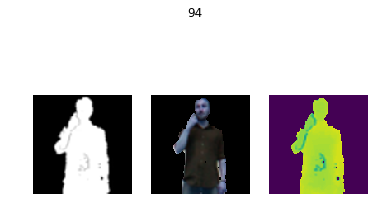

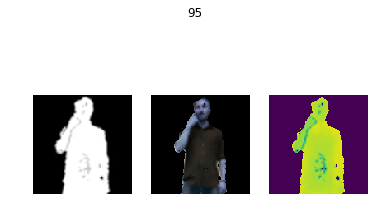

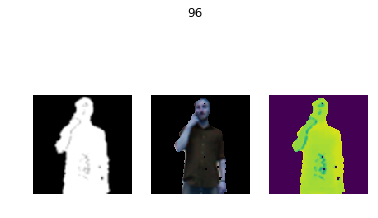

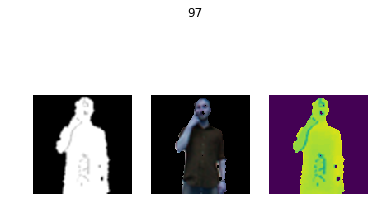

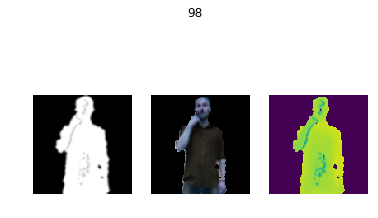

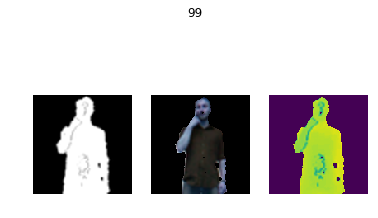

In [10]:
# visualize
for i in range(100):
    if(not data_pp['valid'][i]):
        continue
    
    plot([data_pp['seg'][i], data_pp['rgb'][i], data_pp['dep'][i]], i)

In [9]:
# dump to disk
pickle.dump(data_pp, open("./data_pp/data-%s.pkl" % data_set, 'wb'))
print('done')

done
